In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pathlib import Path
import pickle
from collections import OrderedDict
import pandas as pd
import numpy as np
from scipy import stats
import scipy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 

import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from IPython.display import HTML
import plotly.graph_objects as go

import scipy.stats as st
from collections import defaultdict

import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 500

pio.renderers.default = "png"




WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Statlog (Heart) Data Set
https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/

Attribute Information:
------------------------
      -- 1. age       
      -- 2. sex       
      -- 3. chest pain type  (4 values)       
      -- 4. resting blood pressure  
      -- 5. serum cholestoral in mg/dl      
      -- 6. fasting blood sugar > 120 mg/dl       
      -- 7. resting electrocardiographic results  (values 0,1,2) 
      -- 8. maximum heart rate achieved  
      -- 9. exercise induced angina    
      -- 10. oldpeak = ST depression induced by exercise relative to rest   
      -- 11. the slope of the peak exercise ST segment     
      -- 12. number of major vessels (0-3) colored by flourosopy        
      -- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect     
Final column:
Absence (1) or presence (2) of heart disease

(I will change it to 1 for HD and 0 for none later on)

In [2]:
colnames=['age','sex','chestpain','restbp','cholestoral',
          'bsugar','electrocardiographic','maxhr','angina',
          'oldpeak','slopepexercise','numvessels','thal',
          'heartdisease'
         ]

In [3]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/
df=pd.DataFrame([line.split() for line in open('heart.dat')],columns=colnames)
df=df.astype(float)

In [4]:
df.describe()

,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal,heartdisease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,1.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,2.000000


Normalizing features

In [5]:
featuremeans=df[colnames[:-1]].mean()
featurestds=df[colnames[:-1]].std()
df[colnames[:-1]]=(df[colnames[:-1]]-featuremeans)/featurestds
df.describe()

,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal,heartdisease
count,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,270.000000
mean,3.708967e-16,5.263280e-17,4.276415e-17,5.781384e-16,-2.006625e-16,6.291264e-17,9.292978e-17,-4.934325e-18,2.417819e-16,3.264878e-16,-9.457455e-17,1.151342e-17,-1.348715e-16,1.444444
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.497827
min,-2.792090e+00,-1.447639e+00,-2.288282e+00,-2.090766e+00,-2.392499e+00,-4.162558e-01,-1.024382e+00,-3.396302e+00,-6.999225e-01,-9.168625e-01,-9.524656e-01,-7.102161e-01,-8.740826e-01,1.000000
25%,-7.062560e-01,-1.447639e+00,-1.832185e-01,-6.351301e-01,-7.092654e-01,-4.162558e-01,-1.024382e+00,-7.199336e-01,-6.999225e-01,-9.168625e-01,-9.524656e-01,-7.102161e-01,-8.740826e-01,1.000000
50%,6.220908e-02,6.882217e-01,-1.832185e-01,-7.527007e-02,-9.014507e-02,-4.162558e-01,9.798441e-01,1.649948e-01,-6.999225e-01,-2.183006e-01,6.751655e-01,-7.102161e-01,-8.740826e-01,1.000000
75%,7.208935e-01,6.882217e-01,8.693133e-01,4.845899e-01,5.870178e-01,-4.162558e-01,9.798441e-01,7.045852e-01,1.423438e+00,4.802613e-01,6.751655e-01,3.492223e-01,1.187073e+00,2.000000
max,2.477385e+00,6.882217e-01,8.693133e-01,3.843750e+00,6.081711e+00,2.393471e+00,9.798441e-01,2.258606e+00,1.423438e+00,4.496992e+00,2.302797e+00,2.468099e+00,1.187073e+00,2.000000


In [6]:
df['heartdisease']-=1
df['heartdisease'].mean()

0.4444444444444444

44.4% of the dataset has heartdisease

In [7]:
df.describe()

,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal,heartdisease
count,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,270.000000
mean,3.708967e-16,5.263280e-17,4.276415e-17,5.781384e-16,-2.006625e-16,6.291264e-17,9.292978e-17,-4.934325e-18,2.417819e-16,3.264878e-16,-9.457455e-17,1.151342e-17,-1.348715e-16,0.444444
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.497827
min,-2.792090e+00,-1.447639e+00,-2.288282e+00,-2.090766e+00,-2.392499e+00,-4.162558e-01,-1.024382e+00,-3.396302e+00,-6.999225e-01,-9.168625e-01,-9.524656e-01,-7.102161e-01,-8.740826e-01,0.000000
25%,-7.062560e-01,-1.447639e+00,-1.832185e-01,-6.351301e-01,-7.092654e-01,-4.162558e-01,-1.024382e+00,-7.199336e-01,-6.999225e-01,-9.168625e-01,-9.524656e-01,-7.102161e-01,-8.740826e-01,0.000000
50%,6.220908e-02,6.882217e-01,-1.832185e-01,-7.527007e-02,-9.014507e-02,-4.162558e-01,9.798441e-01,1.649948e-01,-6.999225e-01,-2.183006e-01,6.751655e-01,-7.102161e-01,-8.740826e-01,0.000000
75%,7.208935e-01,6.882217e-01,8.693133e-01,4.845899e-01,5.870178e-01,-4.162558e-01,9.798441e-01,7.045852e-01,1.423438e+00,4.802613e-01,6.751655e-01,3.492223e-01,1.187073e+00,1.000000
max,2.477385e+00,6.882217e-01,8.693133e-01,3.843750e+00,6.081711e+00,2.393471e+00,9.798441e-01,2.258606e+00,1.423438e+00,4.496992e+00,2.302797e+00,2.468099e+00,1.187073e+00,1.000000


### Plotting correlations between the attributes, and to our target variable (heart disease)

Biggest negative correlatioln is maxhr versus age. Makes sense...older people have lower heart rates.

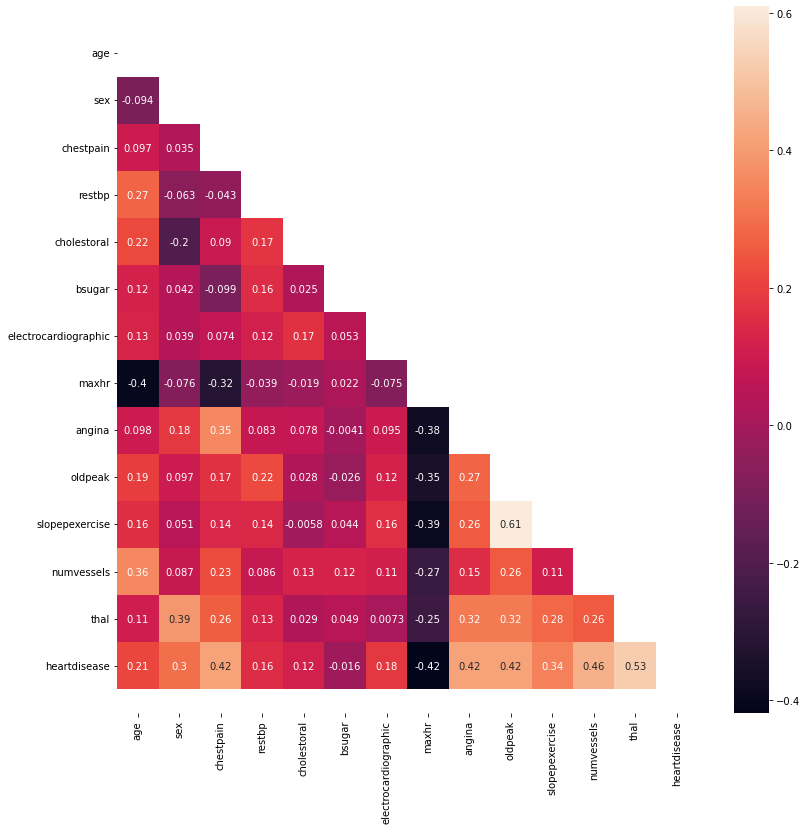

In [8]:
plt.figure(figsize=(13, 13))
corr = df.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr, mask=mask, annot=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

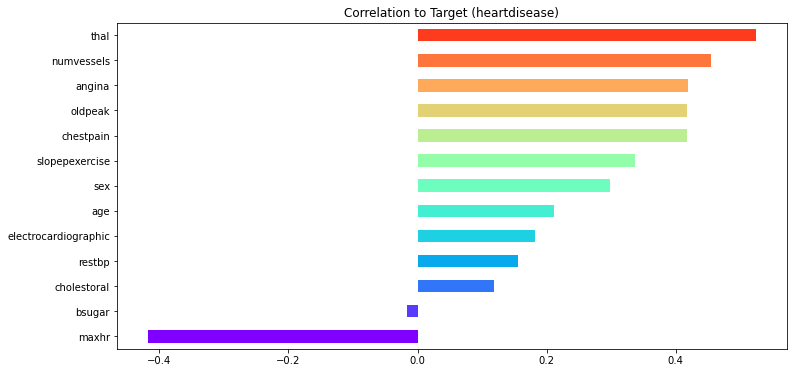


 thal                    0.525020
numvessels              0.455336
angina                  0.419303
oldpeak                 0.417967
chestpain               0.417436
slopepexercise          0.337616
sex                     0.297721
age                     0.212322
electrocardiographic    0.182091
restbp                  0.155383
cholestoral             0.118021
bsugar                 -0.016319
maxhr                  -0.418514
dtype: float64


In [9]:
n_fts = len(df.columns)
colors = cm.rainbow(np.linspace(0, 1, n_fts))

df.drop('heartdisease',axis=1).corrwith(df.heartdisease).sort_values(ascending=True).plot(kind='barh', 
                                                                                     color=colors, figsize=(12, 6))
plt.title('Correlation to Target (heartdisease)')
plt.show()

print('\n',df.drop('heartdisease',axis=1).corrwith(df.heartdisease).sort_values(ascending=False))

# Defining the model 
We will use ALL of the features given, even though another idea is to filter out some of the lower correlations above.


In [10]:
full_model=colnames[-1]+' ~ '+' + '.join(colnames[:-1])
full_model

'heartdisease ~ age + sex + chestpain + restbp + cholestoral + bsugar + electrocardiographic + maxhr + angina + oldpeak + slopepexercise + numvessels + thal'

In [11]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=df,
                            family=pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [12]:
logistic_model.basic_RVs

[Intercept ~ Flat,
 age ~ Normal,
 sex ~ Normal,
 chestpain ~ Normal,
 restbp ~ Normal,
 cholestoral ~ Normal,
 bsugar ~ Normal,
 electrocardiographic ~ Normal,
 maxhr ~ Normal,
 angina ~ Normal,
 oldpeak ~ Normal,
 slopepexercise ~ Normal,
 numvessels ~ Normal,
 thal ~ Normal,
 y ~ Binomial]

## Markov Chain Monte Carlo (MCMC)
Using the NUTS sampler built into PyMC3

This is the long run version of MCMC that other models are compared against

In [13]:
import time
start = time.time()
with logistic_model:
    trace_NUTS  = pm.sample(tune=100000,
                         draws=100000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=3)
mcmcruntime = time.time()-start


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 100_000 tune and 100_000 draw iterations (400_000 + 400_000 draws total) took 1037 seconds.


In [14]:
mcmcruntime 
#This is greater that the reported time above as there are startup and shutdown costs
#in the PYMC3 library.

1187.0307700634003

### Inspect Trace


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


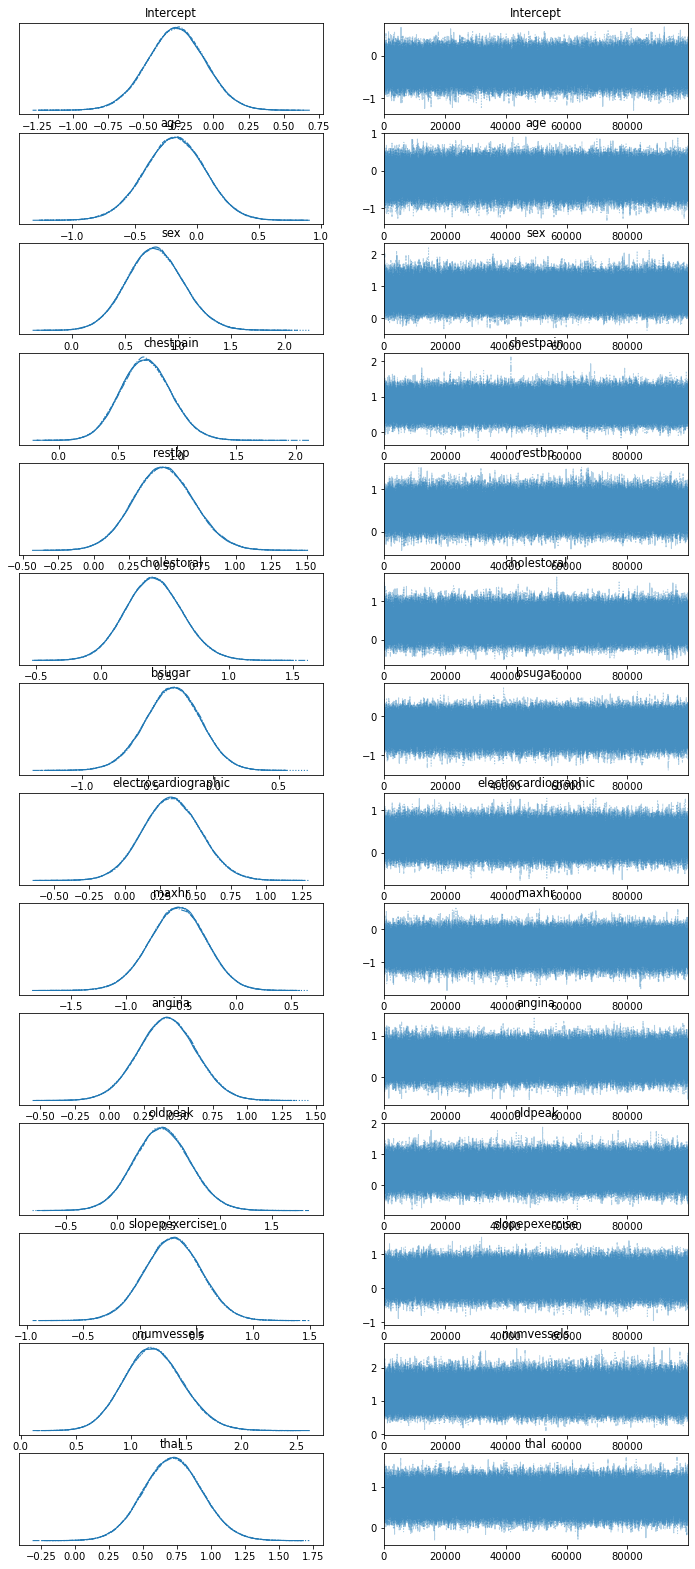

In [15]:
pm.plot_trace(trace_NUTS );


In [16]:
tracedf=pm.trace_to_dataframe(trace_NUTS )
tracedf

,Intercept,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal
0,-0.297183,0.028209,1.077291,1.169263,0.868437,0.369282,-0.558826,-0.050698,-0.541677,0.196765,-0.211456,0.849681,1.356831,0.809061
1,-0.537905,-0.031221,1.311460,0.774373,0.525285,0.384310,-0.920156,0.543560,-0.615326,-0.101370,0.123219,0.878683,1.237393,0.862411
2,-0.472474,0.123024,1.372853,0.693773,0.450806,0.202819,-0.725198,0.615971,-0.781492,0.206140,0.319374,0.818873,1.301834,0.829738
3,0.009283,-0.506918,0.563971,0.731397,0.382178,0.331195,0.075386,-0.210241,-0.831047,0.593833,0.966413,0.216303,1.431084,0.976147
4,-0.243621,-0.107810,0.822571,0.960617,0.694757,0.522189,-0.513748,0.611632,-0.402835,0.206979,0.566783,-0.204520,1.188736,0.909923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,-0.167369,-0.160605,0.922747,0.706236,0.699147,0.206480,-0.387984,0.115888,-0.470310,0.268974,0.550779,0.392015,1.227502,0.986216
399996,-0.479488,0.069513,0.874669,0.583972,0.633371,0.699287,-0.473164,-0.048718,-0.652084,0.037593,0.360163,0.107075,0.746496,0.877219
399997,-0.602276,0.113936,0.877646,0.495060,0.404481,0.721228,-0.358698,0.052151,-0.620594,0.125868,0.487545,-0.039347,0.771971,0.731093
399998,-0.524924,0.053646,1.155785,0.925170,0.366175,0.494940,-0.150962,0.245166,-0.411801,0.599152,0.849958,0.234436,0.887067,0.986678


As seen above, we have all the samples as rows.

In [17]:
mcmcresults=pm.summary(trace_NUTS )
mcmcresults

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.266,0.207,-0.658,0.119,0.0,0.0,564898.0,327794.0,1.0
age,-0.179,0.244,-0.631,0.289,0.0,0.0,494833.0,336968.0,1.0
sex,0.786,0.266,0.288,1.290,0.0,0.0,476060.0,338250.0,1.0
chestpain,0.737,0.215,0.337,1.143,0.0,0.0,529259.0,328325.0,1.0
restbp,0.494,0.214,0.095,0.902,0.0,0.0,492662.0,339399.0,1.0
cholestoral,0.415,0.224,-0.004,0.838,0.0,0.0,511525.0,331314.0,1.0
bsugar,-0.310,0.213,-0.718,0.084,0.0,0.0,504493.0,326505.0,1.0
electrocardiographic,0.331,0.206,-0.054,0.721,0.0,0.0,558742.0,325322.0,1.0
maxhr,-0.534,0.258,-1.019,-0.050,0.0,0.0,512343.0,336829.0,1.0
angina,0.420,0.212,0.022,0.819,0.0,0.0,559286.0,314497.0,1.0


### Posterior Plot


Got error No model on context stack. trying to find log_likelihood in translation.


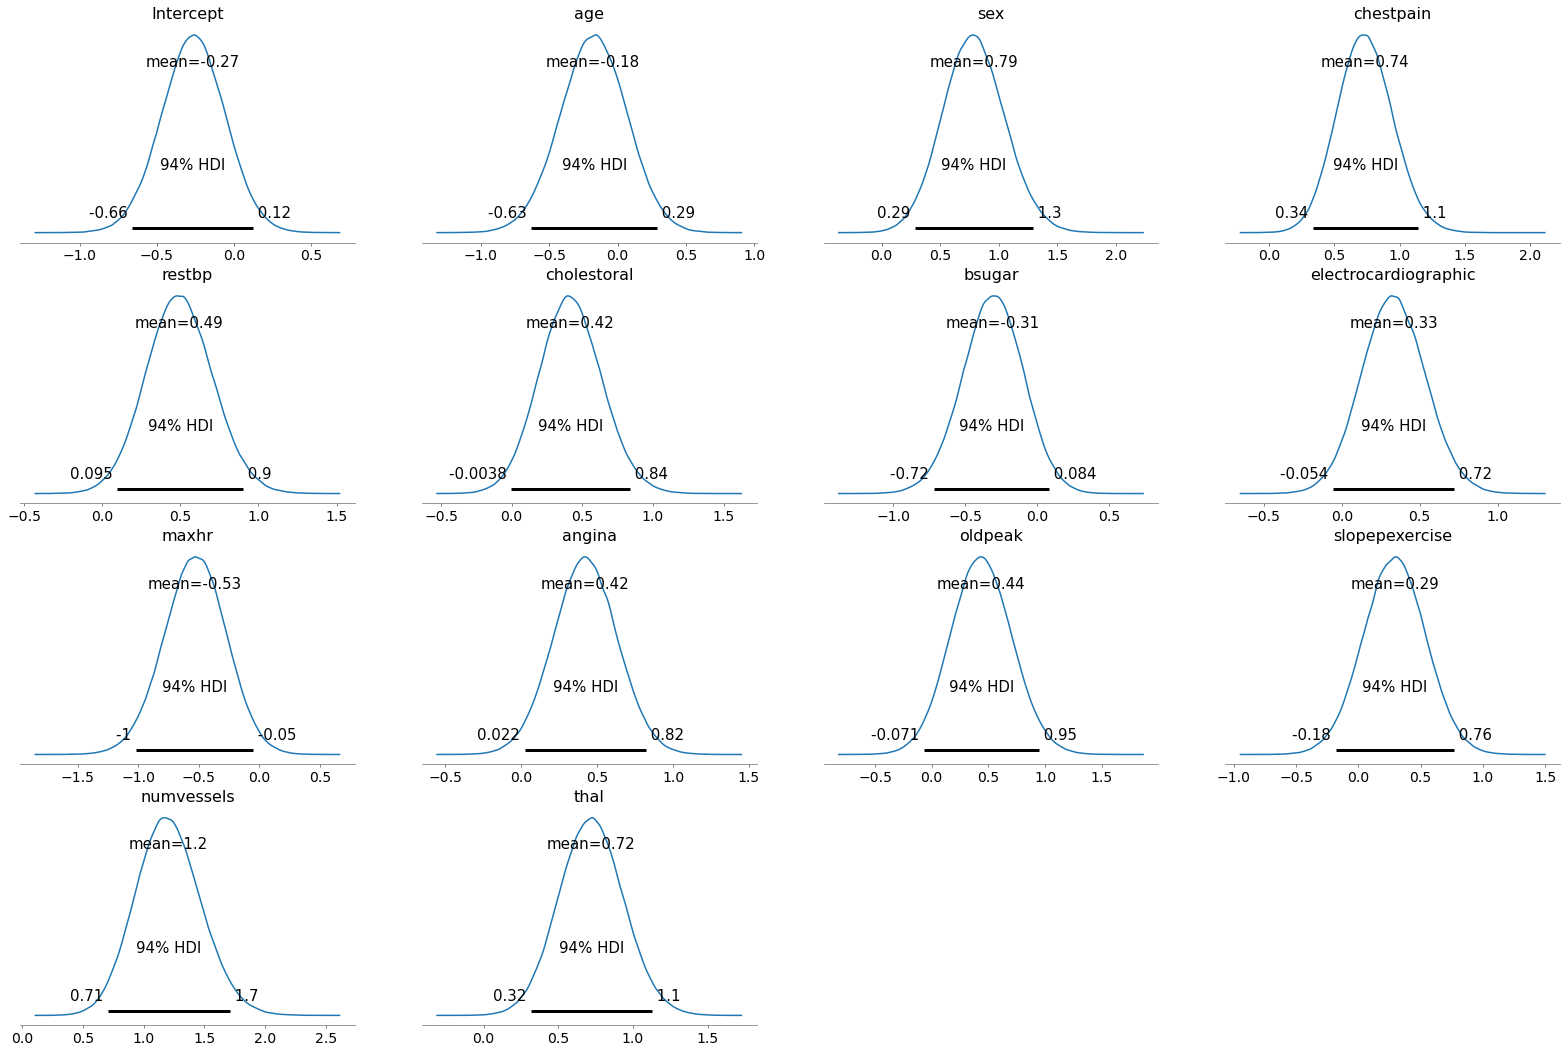

In [18]:
pm.plot_posterior(trace_NUTS);


In [19]:
covactual=tracedf.cov().values
oactual=np.linalg.inv(covactual)

## Visualizing covariance structure of the model's latent variables
### Using MCMC

Got error No model on context stack. trying to find log_likelihood in translation.


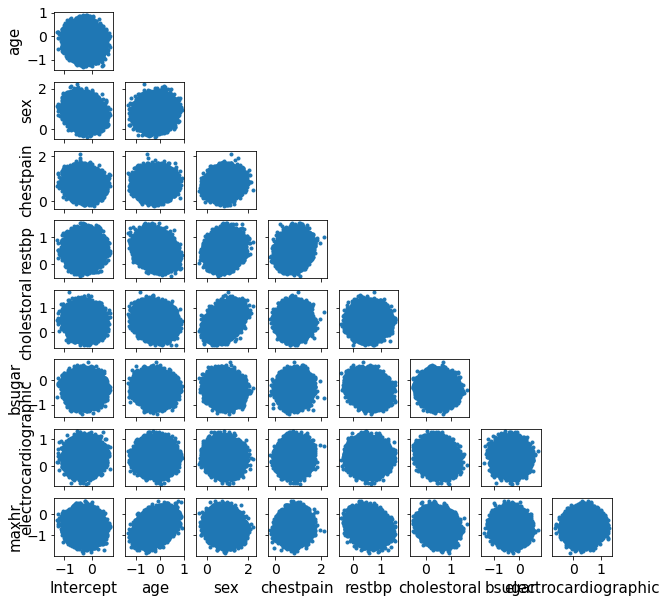

In [20]:
az.plot_pair(trace_NUTS, figsize=(10, 10));


### MCMC captures the covariance structure of the model's latent variables, but it is slower than ADVI

How do we reconcile (1) negative correlation between maxhr and age, (2) the negative correlation between maxhr and heart disease, and (3) the positive correlation between the latent variable related to age with the latent variable related to maxhr? 

According to Journal of the American Medical Association, a higher heart rate INCREASES the chance of heart disease. However, simple correlation results in figure 2 shows that higher heart rate decreases the chance of heart disease. This is likely due to a higher heart rate also capturing younger (smaller age value) individuals, who tend to be healthy. (Albeit, at a given age, a higher heart rate is bad.) Therefore, there is a strong positive covariance between latent variable related to maxhr and the latent variable age. When the model increases exposure to maxhr to capture heart disease, it would naturally falsely predict younger individuals as having heart disease, and this would be solved with a corresponding increased exposure to age. 

Hence, MCMC captures the covariance structure of the model's latent variables, but it is slower than ADVI. (Runtimes will be reported later)


## Varying NUTS samples to get statistical performance vs time graph
### Performance is measured on precision matrix Omega against long run NUTS.


In [21]:
NUTStimeToFN={}

In [35]:
for numsamples in [20*i+10 for i in range(5)]+[20*i+10 for i in range(30)]+[500*i+500 for i in range(5)]+[5000*i+5000 for i in range(2)]:
    start=time.time()
    with logistic_model:
        trace_NUTS2 = pm.sample(tune=numsamples,
                             draws=numsamples,
                             chains=4,
                             init = 'adapt_diag',
                             cores=1)
        #Note: for apples-to-apples comparision, we use only one core since the same 
        #will be done for the other methods
    rt=time.time()-start
    tracedf2=pm.trace_to_dataframe(trace_NUTS2)
    cov2=tracedf2.cov().values
    o2=np.linalg.inv(cov2)
    fn=np.linalg.norm(oactual-o2)
    NUTStimeToFN[rt]=fn
    print('NUTS Runtime={:.2f} FN={:.2f}'.format(rt,fn))


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 0 seconds.


NUTS Runtime=8.80 FN=302.10


Only 30 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 30 tune and 30 draw iterations (120 + 120 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9662043329102666, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=11.83 FN=57.77


Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.9169075083852769, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9294106194534686, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9215135941367381, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=9.93 FN=35.70


Only 70 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 70 tune and 70 draw iterations (280 + 280 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.9028873897332176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9130165737086591, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9193589901656046, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9213704147209774, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=11.73 FN=36.31


Only 90 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 90 tune and 90 draw iterations (360 + 360 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.9048797904342347, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9053195282553945, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9025367355387501, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9163657242694592, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=12.13 FN=26.01


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 1 seconds.


NUTS Runtime=8.63 FN=210.36


Only 30 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 30 tune and 30 draw iterations (120 + 120 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9551192647597103, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=9.89 FN=83.56


Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.9218557278370377, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9125126723068405, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9124735438115539, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9390266318183639, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=10.70 FN=35.64


Only 70 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 70 tune and 70 draw iterations (280 + 280 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.9051310303540366, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9287007351598342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894384654966298, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=10.79 FN=34.71


Only 90 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 90 tune and 90 draw iterations (360 + 360 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.9135360236202886, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9002857048440246, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9145202219527232, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9268313422233073, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=11.16 FN=27.64


Only 110 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 110 tune and 110 draw iterations (440 + 440 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.9626430375986649, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9573438748628564, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9579415499759228, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9570111487832222, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=11.20 FN=23.25


Only 130 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 130 tune and 130 draw iterations (520 + 520 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.9199421881762815, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9267780311095287, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9307035803081176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9241925945805077, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=11.74 FN=20.84


Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 150 tune and 150 draw iterations (600 + 600 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.9013117666444157, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9240754454026369, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9038764090723324, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012202313038965, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=17.93 FN=22.82


Only 170 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 170 tune and 170 draw iterations (680 + 680 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8899141497045103, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892999536654471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8964399102396148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898264682179444, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=11.39 FN=19.06


Only 190 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 190 tune and 190 draw iterations (760 + 760 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8873117938098611, but should be close to 0.8. Try to increase the number of tuning steps.


NUTS Runtime=11.89 FN=19.69


Only 210 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 210 tune and 210 draw iterations (840 + 840 draws total) took 6 seconds.


NUTS Runtime=13.64 FN=18.61


Only 230 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 230 tune and 230 draw iterations (920 + 920 draws total) took 5 seconds.


NUTS Runtime=13.36 FN=13.90


Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 250 tune and 250 draw iterations (1_000 + 1_000 draws total) took 7 seconds.


NUTS Runtime=15.24 FN=13.77


Only 270 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 270 tune and 270 draw iterations (1_080 + 1_080 draws total) took 8 seconds.


NUTS Runtime=17.18 FN=13.41


Only 290 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 290 tune and 290 draw iterations (1_160 + 1_160 draws total) took 8 seconds.


NUTS Runtime=14.91 FN=14.90


Only 310 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 310 tune and 310 draw iterations (1_240 + 1_240 draws total) took 8 seconds.


NUTS Runtime=18.07 FN=12.49


Only 330 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 330 tune and 330 draw iterations (1_320 + 1_320 draws total) took 9 seconds.


NUTS Runtime=16.67 FN=12.58


Only 350 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 350 tune and 350 draw iterations (1_400 + 1_400 draws total) took 8 seconds.


NUTS Runtime=16.42 FN=11.25


Only 370 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 370 tune and 370 draw iterations (1_480 + 1_480 draws total) took 8 seconds.


NUTS Runtime=15.78 FN=10.09


Only 390 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 390 tune and 390 draw iterations (1_560 + 1_560 draws total) took 8 seconds.


NUTS Runtime=14.82 FN=10.06


Only 410 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 410 tune and 410 draw iterations (1_640 + 1_640 draws total) took 9 seconds.


NUTS Runtime=16.25 FN=10.53


Only 430 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 430 tune and 430 draw iterations (1_720 + 1_720 draws total) took 9 seconds.


NUTS Runtime=16.48 FN=11.13


Only 450 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 450 tune and 450 draw iterations (1_800 + 1_800 draws total) took 9 seconds.


NUTS Runtime=16.52 FN=10.71


Only 470 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 470 tune and 470 draw iterations (1_880 + 1_880 draws total) took 10 seconds.


NUTS Runtime=17.41 FN=10.49


Only 490 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 490 tune and 490 draw iterations (1_960 + 1_960 draws total) took 10 seconds.


NUTS Runtime=18.18 FN=9.51


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 510 tune and 510 draw iterations (2_040 + 2_040 draws total) took 10 seconds.


NUTS Runtime=18.25 FN=10.26


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 530 tune and 530 draw iterations (2_120 + 2_120 draws total) took 11 seconds.


NUTS Runtime=18.92 FN=8.92


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 550 tune and 550 draw iterations (2_200 + 2_200 draws total) took 12 seconds.


NUTS Runtime=20.05 FN=10.01


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 570 tune and 570 draw iterations (2_280 + 2_280 draws total) took 12 seconds.


NUTS Runtime=20.77 FN=9.22


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 590 tune and 590 draw iterations (2_360 + 2_360 draws total) took 15 seconds.


NUTS Runtime=24.21 FN=9.89


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


NUTS Runtime=18.73 FN=9.87


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


NUTS Runtime=28.92 FN=5.74


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 27 seconds.


NUTS Runtime=37.32 FN=4.83


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.


NUTS Runtime=53.65 FN=5.72


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 57 seconds.


NUTS Runtime=68.03 FN=5.67


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 103 seconds.


NUTS Runtime=116.99 FN=3.34


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 206 seconds.


NUTS Runtime=227.23 FN=2.36


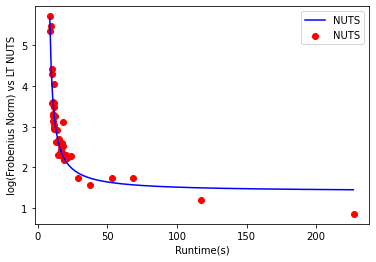

In [36]:
XY=sorted(zip(NUTStimeToFN.keys(),NUTStimeToFN.values()))
X=np.array([x[0] for x in XY])
y=np.array([np.log(x[1]) for x in XY])
plt.xlabel('Runtime(s)')
plt.ylabel('log(Frobenius Norm) vs LT NUTS')
plt.scatter(X, y,c="red",label='NUTS')

params,_=scipy.optimize.curve_fit(lambda t,a,b,c: a+b*(1/np.clip(t+c,0.0001,None)),  X,  y)
a=params[0]
b=params[1]
c=params[2]
def fit(t):
    return a+b*(1/np.clip(t+c,0.0001,None))
plt.plot(np.arange(min(X),max(X)), fit(np.arange(min(X),max(X))), 'r',c="blue",label='NUTS')

plt.legend()



## Comparing point estimates of NUTS vs Sklearn/SMF

### Logistic Regression based on NUTS sampler versus  sklearn.linear_model.LogisticRegression


In [371]:
start = time.time()
from sklearn.linear_model import LogisticRegression
XData=df[colnames[:-1]].values
yData=df[colnames[-1]].values
clf = LogisticRegression().fit(XData, yData)
#From https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients

# Calculate matrix of predicted class probabilities.
# Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
predProbs = clf.predict_proba(XData)


# Design matrix -- add column of 1's at the beginning of your X_train matrix
X_design = np.hstack([np.ones((XData.shape[0], 1)), XData])

# While V should be a diagonal matrix of size (n,n), we keep it as (n,1) here to save space.
V = np.product(predProbs, axis=1)

# Covariance matrix
covLogit = np.linalg.pinv(np.dot(X_design.T* V, X_design))

# Standard errors
print("Coefs: ", clf.coef_)
print("Intercept: ", clf.intercept_)
print("Standard errors: ", np.sqrt(np.diag(covLogit)))
print("Average Standard errors: ", np.mean(np.sqrt(np.diag(covLogit))))
print("Average u0 = {}".format(np.sqrt(np.diag(om)).mean()))
print()
sklearnruntime = time.time()-start
accuracy=clf.score(XData, yData)
print('SKlearn Logistic Regression Accuracy ={:.3f} Runtime(s) = {:.2f}'.format(accuracy,sklearnruntime))

sklearnom=np.linalg.inv(covLogit)
sklearnfn=np.linalg.norm(oactual-sklearnom)
print('For SKLearn, FN ={} log(FN)={}'.format(sklearnfn,np.log(sklearnfn)))



Coefs:  [[-0.12580084  0.66877726  0.63684872  0.40730943  0.33883204 -0.25416623
   0.29079339 -0.45851916  0.37957175  0.39221287  0.25308226  1.01952846
   0.64987814]]
Intercept:  [-0.2538742]
Standard errors:  [0.19319991 0.22914322 0.24515721 0.20025606 0.1995826  0.20539227
 0.19903133 0.19338214 0.23922496 0.19880964 0.25523453 0.23525576
 0.24481765 0.20236305]
Average Standard errors:  0.21720359511596882
Average u0 = 4.889828965258496

SKlearn Logistic Regression Accuracy =0.852 Runtime(s) = 0.04
For SKLearn, FN =14.699078677126938 log(FN)=2.687784816795151


Bootstrapping estimate of u0

In [138]:
np.sqrt(np.diag(om)).mean()

5.237902795030971

In [139]:
np.sqrt(np.diag(om)).min()

4.611216063346413

In [140]:
u0est=np.sqrt(np.diag(om)).min()

In [141]:
u0est

4.611216063346413

Now compare to results from MCMC

In [27]:
clf.intercept_[0]=mcmcresults['mean'].values[0]
clf.coef_[0]=mcmcresults['mean'].values[1:]
accuracy=clf.score(XData, yData)
print('MCMC (NUTS) Accuracy ={:.3f} Runtime(s) = {:.2f}'.format(accuracy,mcmcruntime))

MCMC (NUTS) Accuracy =0.856 Runtime(s) = 1187.03


Note that sklearn does not give much information on the distribution of the model's latent variables, but just the point estimates and at best standard errors that assume a fixed structure.


## Automatic Differentation Variational Inference (ADVI)

In [31]:
ADVItimeToFN={}

In [37]:
for nums in [5000*(x+1) for x in range(10)]: #+[1000*(x+1) for x in range(10)]
    start = time.time()
    with logistic_model:
        callback = CheckParametersConvergence(diff='absolute')
        approx = pm.fit(n=nums, callbacks=[callback])
    trace_advi = approx.sample(2000)
    samples=[]
    for v in trace_advi._straces[0].samples.values():
        samples.append(v)
    samples=np.array(samples)
    covadvi=np.cov(samples)
    oadvi=np.linalg.inv(covadvi)
    fn=np.linalg.norm(oactual-oadvi)
    adviruntime=time.time()-start
    ADVItimeToFN[adviruntime]=fn
    

Finished [100%]: Average Loss = 213.68


Finished [100%]: Average Loss = 202.39


Finished [100%]: Average Loss = 201.49


Finished [100%]: Average Loss = 201.47


Finished [100%]: Average Loss = 201.34


Finished [100%]: Average Loss = 201.33


Finished [100%]: Average Loss = 201.43


Finished [100%]: Average Loss = 201.35


Finished [100%]: Average Loss = 201.49


Finished [100%]: Average Loss = 201.23


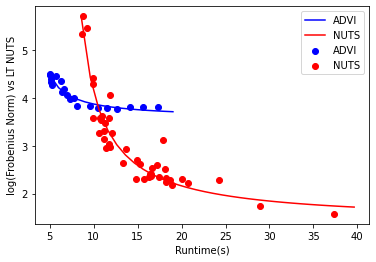

In [38]:
plt.xlabel('Runtime(s)')
plt.ylabel('log(Frobenius Norm) vs LT NUTS')
maxX=40

for res,l,col in [(ADVItimeToFN,'ADVI','blue'),(NUTStimeToFN,'NUTS','red')]:
    XY=sorted(zip(res.keys(),res.values()))
    X=np.array([x[0] for x in XY])
    y=np.array([np.log(x[1]) for x in XY])
    plt.scatter(X[X<maxX], y[X<maxX],c=col,label=l)
    #fit,param=np.polynomial.polynomial.Polynomial.fit(X,y, 6, full=True)
    #params,_=scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(t-c**2),  X,  y)
    params,_=scipy.optimize.curve_fit(lambda t,a,b,c: a+b*(1/np.clip(t+c,0.0001,None)),  X,  y)
    a=params[0]
    b=params[1]
    c=params[2]
    def fit(t):
        return a+b*(1/np.clip(t+c,0.0001,None))
    plotrange=np.arange(min(X),min(max(X)*1.1,maxX))
    plt.plot(plotrange, fit(plotrange), 'r',c=col,label=l)

plt.legend()



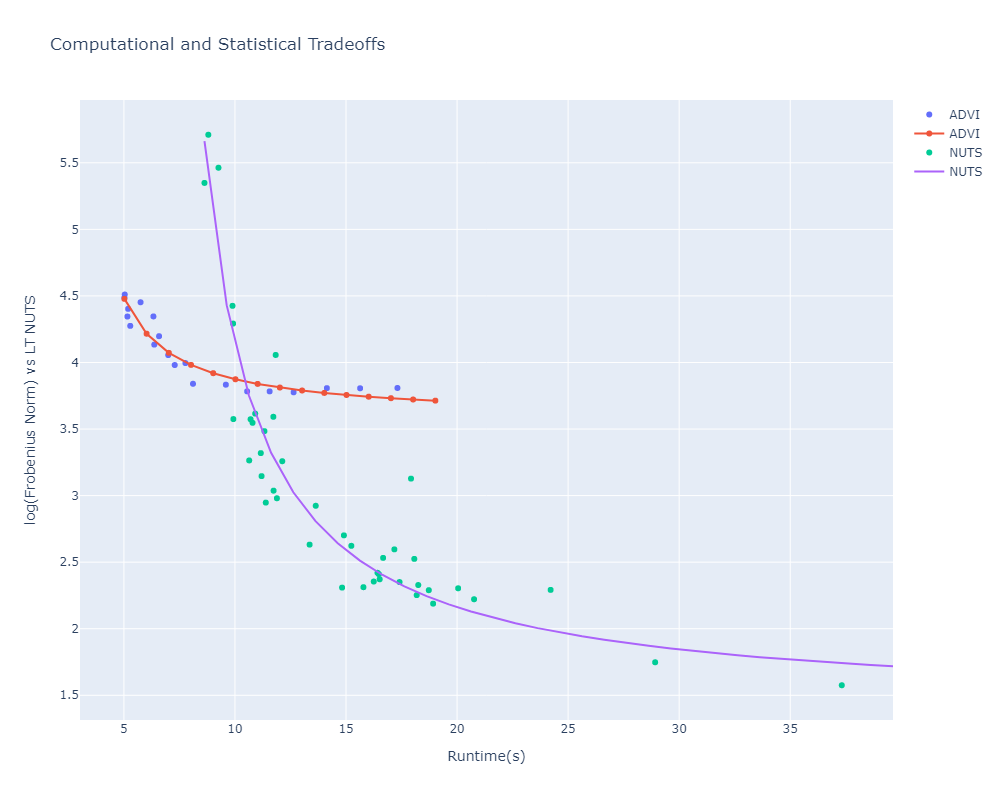

In [366]:
fig = go.Figure()

maxX=40
for res,l,col in [(ADVItimeToFN,'ADVI','blue'),(NUTStimeToFN,'NUTS','red')]:
    XY=sorted(zip(res.keys(),res.values()))
    X=np.array([x[0] for x in XY])
    y=np.array([np.log(x[1]) for x in XY])
    trace = go.Scatter(x=X[X<maxX], y=y[X<maxX],mode='markers',name=l)
    fig.add_trace(trace)
    #fit,param=np.polynomial.polynomial.Polynomial.fit(X,y, 6, full=True)
    #params,_=scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(t-c**2),  X,  y)
    params,_=scipy.optimize.curve_fit(lambda t,a,b,c: a+b*(1/np.clip(t+c,0.0001,None)),  X,  y)
    a=params[0]
    b=params[1]
    c=params[2]
    def fit(t):
        return a+b*(1/np.clip(t+c,0.0001,None))
    plotrange=np.arange(min(X),min(max(X)*1.1,maxX))
    trace = go.Scatter(x=plotrange, y=fit(plotrange),name=l)
    fig.add_trace(trace)

fig.update_layout(title='Computational and Statistical Tradeoffs')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.show()


In [40]:
adviruntime

17.316130876541138

In [41]:
adviresults=pm.summary(trace_advi)
adviresults


Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.269,0.212,-0.660,0.116,0.005,0.003,1990.0,1832.0,NaN
age,-0.185,0.219,-0.596,0.220,0.005,0.003,2157.0,2092.0,NaN
sex,0.786,0.231,0.358,1.225,0.005,0.004,2009.0,1875.0,NaN
chestpain,0.739,0.217,0.322,1.149,0.005,0.004,1818.0,1812.0,NaN
restbp,0.497,0.213,0.108,0.891,0.005,0.003,1968.0,1614.0,NaN
cholestoral,0.406,0.210,-0.004,0.780,0.005,0.003,1884.0,2047.0,NaN
bsugar,-0.311,0.212,-0.678,0.108,0.005,0.003,1915.0,1959.0,NaN
electrocardiographic,0.336,0.214,-0.073,0.720,0.005,0.003,1952.0,1960.0,NaN
maxhr,-0.544,0.241,-1.025,-0.120,0.006,0.004,1907.0,1736.0,NaN
angina,0.435,0.222,0.041,0.873,0.005,0.004,1746.0,1959.0,NaN


In [42]:
clf.intercept_[0]=adviresults['mean'].values[0]
clf.coef_[0]=adviresults['mean'].values[1:]
accuracy=clf.score(XData, yData)
print('ADVI Accuracy ={:.3f} Runtime(s) = {:.2f}'.format(accuracy,adviruntime))

ADVI Accuracy =0.856 Runtime(s) = 17.32


Sklearn's logistic regression is the fastest for this dataset.

ADVI is the 2nd fastest.

Finally MCMC is the slowest.

They all have the same accuracy using the mean parameters but MCMC captures the covariance structure best as we will show in the next section


## Visualizing covariance structure of the model's latent variables


### Using ADVI

Got error No model on context stack. trying to find log_likelihood in translation.


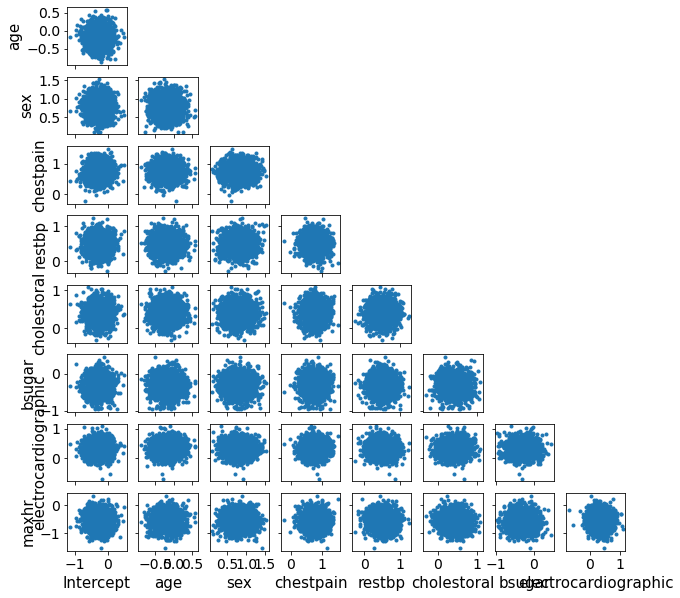

In [43]:
az.plot_pair(trace_advi, figsize=(10, 10));


ADVI does not capture interactions between variables because of the mean field approximation.
The covariance matrix is a trivial diagonal matrix and so it underestimates the overall variance. 

Notably, the covariance between age and heart rate is not captured.

### Calculate FN for ADVI


In [44]:
samples=[]
for v in trace_advi._straces[0].samples.values():
    samples.append(v)
samples=np.array(samples)
samples

array([[-0.45281335, -0.73760993, -0.37846689, ..., -0.06706211,
        -0.44020846, -0.41943133],
       [-0.17490621, -0.19372323, -0.28058651, ...,  0.33312716,
        -0.11399424, -0.01207965],
       [ 0.98328348,  0.87920443,  1.11254018, ...,  0.61212975,
         0.92351451,  0.64649084],
       ...,
       [ 0.07562456,  0.46020811, -0.00770811, ...,  0.54329231,
         0.22771543,  0.3980355 ],
       [ 1.23848294,  1.35948395,  1.19750428, ...,  1.33278751,
         1.37910839,  0.85799521],
       [ 0.8169551 ,  0.56042948,  0.84422037, ...,  0.68507404,
         0.49343218,  0.63011616]])

In [45]:
covadvi=np.cov(samples)
oadvi=np.linalg.inv(covadvi)

As expected the sample covariance from ADVI is largely a diagonal matrix

In [46]:
covadvi

array([[ 4.47741910e-02, -7.58346330e-04,  6.01363198e-04,
         1.05698278e-03, -8.25963878e-04,  6.86092034e-05,
         5.11907134e-04, -6.16268621e-04, -5.49292413e-04,
         9.59691471e-04,  9.81770015e-04,  9.10245431e-08,
        -1.77022855e-03, -4.25497319e-04],
       [-7.58346330e-04,  4.80581788e-02, -2.49462620e-03,
        -4.74707179e-04,  7.87586852e-04, -7.43449200e-04,
        -1.28083622e-03,  1.23423092e-03,  1.03128118e-03,
        -1.13796104e-03, -1.25181551e-03,  4.17763543e-04,
         1.32200737e-03, -1.01335055e-03],
       [ 6.01363198e-04, -2.49462620e-03,  5.35512649e-02,
        -3.66414628e-04,  1.31139707e-03,  1.72624677e-04,
         1.16659956e-03, -9.30843015e-04,  5.31372560e-04,
         3.96319820e-05, -2.91514458e-03, -7.55989988e-04,
         6.88459363e-04,  4.38718787e-04],
       [ 1.05698278e-03, -4.74707179e-04, -3.66414628e-04,
         4.72096615e-02,  4.38314211e-04,  1.04714928e-03,
        -1.14117044e-04,  2.03658684e-04,  4.

In [47]:

om=np.linalg.inv(covadvi)
fn=np.linalg.norm(oactual-om)
print('For ADVI, FN ={} log(FN)={}'.format(fn,np.log(fn)))

For ADVI, FN =45.0825204796295 log(FN)=3.808494598869236


# Now doing VI with non-trival covariance as in capstone pdf.


In [48]:
mu_star=mcmcresults['mean'].values
covactual=tracedf.cov().values
oactual=np.linalg.inv(covactual)
d=len(mu_star)
oactual.shape

(14, 14)

In [49]:

def omega(u0,U,Λ):
    return np.identity(d)*u0**2 + np.matmul(np.matmul(U,Λ),U.T)

def omega2(oactual,U,Λ):
    return np.diag(oactual)*np.identity(d) + np.matmul(np.matmul(U,Λ),U.T)

## First using phi by querying versus log pdf based on $\mu^*$ and $\Omega^*$
(This runs faster as we do not have to evaluate versus samples of "x")

In [50]:
def phi(theta):
    return 8.5-scipy.stats.multivariate_normal.logpdf(theta, mean=mu_star, cov=covactual, allow_singular=False)


A good phi value:

In [51]:
phi(mu_star)

0.01990843060973546

A bad phi value:

In [52]:
phi(np.zeros(d))

39.227481350295974

In [53]:
def phi(theta):
    if len(theta.shape)>1:
        ps=[]
        for t in theta:
            ps.append(phi(t))
        return np.array(ps)
    clf.intercept_[0]=theta[0]
    clf.coef_[0]=theta[1:]
    return ((clf.predict_proba(XData)[:,1]-yData)**2).sum()

In [54]:
phi(mu_star)

27.960776997364135

In [55]:
phi(np.zeros(d))

67.5

In [56]:
def getSamples(mu_star,om,num_samples): #Sample as per equation 6
    thiscov=np.linalg.inv(om)
    samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
    phis=phi(samples)
    return samples,phis


## Fixing mathematical/performance defects in capstone pdf
### Question about demeaning variables (phi,theta)



In [57]:
FNByMethod=defaultdict(list)

for demeanphi in [True, False]:
    for demeantheta in [True, False]:
        p=14
        Λ = np.identity(p)
        U=np.eye(d,p)
        u0=1
        u0t,Ut,Λt=u0,U,Λ
        start=time.time()

        for t in range(2000):

            om=omega(u0t,Ut,Λt) #as per pdf 165

            num_samples=1000
            samples,phis=getSamples(mu_star,om,num_samples) #Sample as per equation 6
                        
            if demeanphi:
                phis-=phis.mean()
            expphi=np.abs(phis).mean()        

            ht=0.01/(1+expphi)

            t2sum=0
            for thisphi,thetajt in zip(phis,samples):
                if demeantheta:
                    thetajt=(thetajt-mu_star).reshape((d,1))
                else:
                    thetajt=(thetajt).reshape((d,1))
                t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            t2sum/=num_samples
            Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)

            #update as per equation 8
            Ut, r = scipy.linalg.qr(Ut,mode='economic')

            if t%10==0: 
                #updating eigenvalues as per pdf 191
                om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
                for i in range(p):
                    ui=Ut[:,i]
                    Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
                    
                om=omega(u0t,Ut,Λt) #as per pdf 165
                fn=np.linalg.norm(oactual-om) #suggested by mentor: Frobenius Norm
                estart=time.time()-start
                FNByMethod[(demeanphi,demeantheta)].append((estart,fn))
                if estart>60:
                    break
                print('demeanphi={} demeantheta={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(demeanphi,demeantheta,t,expphi,fn))
                
                
        

demeanphi=True demeantheta=True epoach 0 avg phi 8.4527 Frobenius Norm 41.8980
demeanphi=True demeantheta=True epoach 10 avg phi 0.8359 Frobenius Norm 40.7605
demeanphi=True demeantheta=True epoach 20 avg phi 0.7840 Frobenius Norm 38.0840
demeanphi=True demeantheta=True epoach 30 avg phi 0.7915 Frobenius Norm 35.5769
demeanphi=True demeantheta=True epoach 40 avg phi 0.7969 Frobenius Norm 33.8196
demeanphi=True demeantheta=True epoach 50 avg phi 0.7698 Frobenius Norm 31.2227
demeanphi=True demeantheta=True epoach 60 avg phi 0.8088 Frobenius Norm 29.1652
demeanphi=True demeantheta=True epoach 70 avg phi 0.7668 Frobenius Norm 27.6345
demeanphi=True demeantheta=True epoach 80 avg phi 0.7631 Frobenius Norm 25.5785
demeanphi=True demeantheta=True epoach 90 avg phi 0.8043 Frobenius Norm 23.8908
demeanphi=True demeantheta=True epoach 100 avg phi 0.7578 Frobenius Norm 22.9402
demeanphi=True demeantheta=True epoach 110 avg phi 0.7498 Frobenius Norm 22.9270
demeanphi=True demeantheta=True epoach 

demeanphi=False demeantheta=True epoach 340 avg phi 30.0577 Frobenius Norm 39.0231
demeanphi=False demeantheta=True epoach 350 avg phi 30.0242 Frobenius Norm 38.9311
demeanphi=False demeantheta=True epoach 360 avg phi 30.0378 Frobenius Norm 39.0719
demeanphi=False demeantheta=False epoach 0 avg phi 49.0532 Frobenius Norm 41.9226
demeanphi=False demeantheta=False epoach 10 avg phi 30.1033 Frobenius Norm 40.5939
demeanphi=False demeantheta=False epoach 20 avg phi 30.0249 Frobenius Norm 40.2117
demeanphi=False demeantheta=False epoach 30 avg phi 30.0219 Frobenius Norm 39.9454
demeanphi=False demeantheta=False epoach 40 avg phi 30.0677 Frobenius Norm 40.1283
demeanphi=False demeantheta=False epoach 50 avg phi 30.0147 Frobenius Norm 40.0201
demeanphi=False demeantheta=False epoach 60 avg phi 30.1019 Frobenius Norm 39.9429
demeanphi=False demeantheta=False epoach 70 avg phi 30.0533 Frobenius Norm 39.8968
demeanphi=False demeantheta=False epoach 80 avg phi 30.0535 Frobenius Norm 39.8612
demea

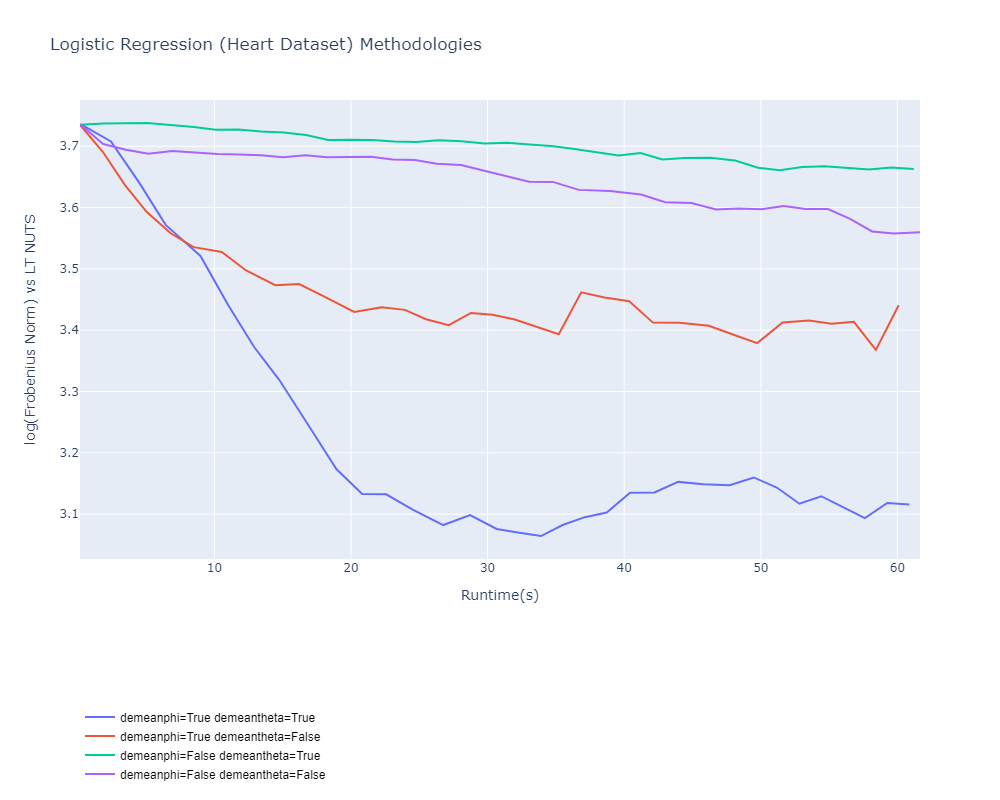

In [362]:
fig = go.Figure()

for demeanphi in [True, False]:
    for demeantheta in [True, False]:
        XY=FNByMethod[(demeanphi,demeantheta)]
        y=np.log(np.array([y for x,y in XY]))
        x=np.array([x for x,y in XY])
        trace = go.Scatter(x=x, y=y, 
                           name='demeanphi={} demeantheta={}'.format(demeanphi,demeantheta))
        fig.add_trace(trace)

fig.update_layout(title='Logistic Regression (Heart Dataset) Methodologies')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.update_layout(
    legend=dict(
        x=0,
        y=-0.5,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)
fig.show()

## Question about sample size
(Answer is smaller first and bigger later.)

In [59]:
FNByMethod3=defaultdict(list)

for num_samples2 in [0,200,400,800]:
    p=14
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ
    start=time.time()

    for t in range(10000):
        om=omega(u0t,Ut,Λt) #as per pdf 165
        
        num_samples=num_samples2
        if not num_samples:
            num_samples=200+t*3

        samples,phis=getSamples(mu_star,om,num_samples) #Sample as per equation 6
        phis-=phis.mean()
        expphi=np.abs(phis).mean()        

        ht=0.01/(1+expphi)

        t2sum=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
        t2sum/=num_samples
        Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)

        #update as per equation 8
        Ut, r = scipy.linalg.qr(Ut,mode='economic')

        if t%10==0: 
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1

            om=omega(u0t,Ut,Λt) #as per pdf 165
            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            estart=time.time()-start
            FNByMethod3[(num_samples2)].append((estart,fn))
            if estart>30:
                break
            print('num_samples={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(num_samples,t,expphi,fn))


num_samples=200 epoach 0 avg phi 8.5556 Frobenius Norm 41.8976
num_samples=230 epoach 10 avg phi 0.7643 Frobenius Norm 40.6066
num_samples=260 epoach 20 avg phi 0.8434 Frobenius Norm 38.3998
num_samples=290 epoach 30 avg phi 0.8043 Frobenius Norm 36.2870
num_samples=320 epoach 40 avg phi 0.7843 Frobenius Norm 34.7195
num_samples=350 epoach 50 avg phi 0.7918 Frobenius Norm 33.0439
num_samples=380 epoach 60 avg phi 0.7836 Frobenius Norm 30.9458
num_samples=410 epoach 70 avg phi 0.8537 Frobenius Norm 28.0646
num_samples=440 epoach 80 avg phi 0.8058 Frobenius Norm 26.4878
num_samples=470 epoach 90 avg phi 0.7998 Frobenius Norm 25.7755
num_samples=500 epoach 100 avg phi 0.7595 Frobenius Norm 24.9480
num_samples=530 epoach 110 avg phi 0.7597 Frobenius Norm 24.2234
num_samples=560 epoach 120 avg phi 0.7929 Frobenius Norm 23.9329
num_samples=590 epoach 130 avg phi 0.7303 Frobenius Norm 22.8404
num_samples=620 epoach 140 avg phi 0.7792 Frobenius Norm 22.9425
num_samples=650 epoach 150 avg phi 0

num_samples=400 epoach 150 avg phi 0.8005 Frobenius Norm 23.0804
num_samples=400 epoach 160 avg phi 0.8089 Frobenius Norm 22.6270
num_samples=400 epoach 170 avg phi 0.7587 Frobenius Norm 22.7833
num_samples=400 epoach 180 avg phi 0.7312 Frobenius Norm 23.0617
num_samples=400 epoach 190 avg phi 0.7258 Frobenius Norm 22.1216
num_samples=400 epoach 200 avg phi 0.7092 Frobenius Norm 22.0974
num_samples=400 epoach 210 avg phi 0.7696 Frobenius Norm 21.9032
num_samples=400 epoach 220 avg phi 0.8234 Frobenius Norm 22.8137
num_samples=400 epoach 230 avg phi 0.7820 Frobenius Norm 23.4128
num_samples=400 epoach 240 avg phi 0.8309 Frobenius Norm 22.4866
num_samples=400 epoach 250 avg phi 0.7906 Frobenius Norm 22.2801
num_samples=400 epoach 260 avg phi 0.7860 Frobenius Norm 21.9629
num_samples=400 epoach 270 avg phi 0.8125 Frobenius Norm 22.0656
num_samples=400 epoach 280 avg phi 0.7892 Frobenius Norm 22.6474
num_samples=400 epoach 290 avg phi 0.6692 Frobenius Norm 23.4715
num_samples=400 epoach 30

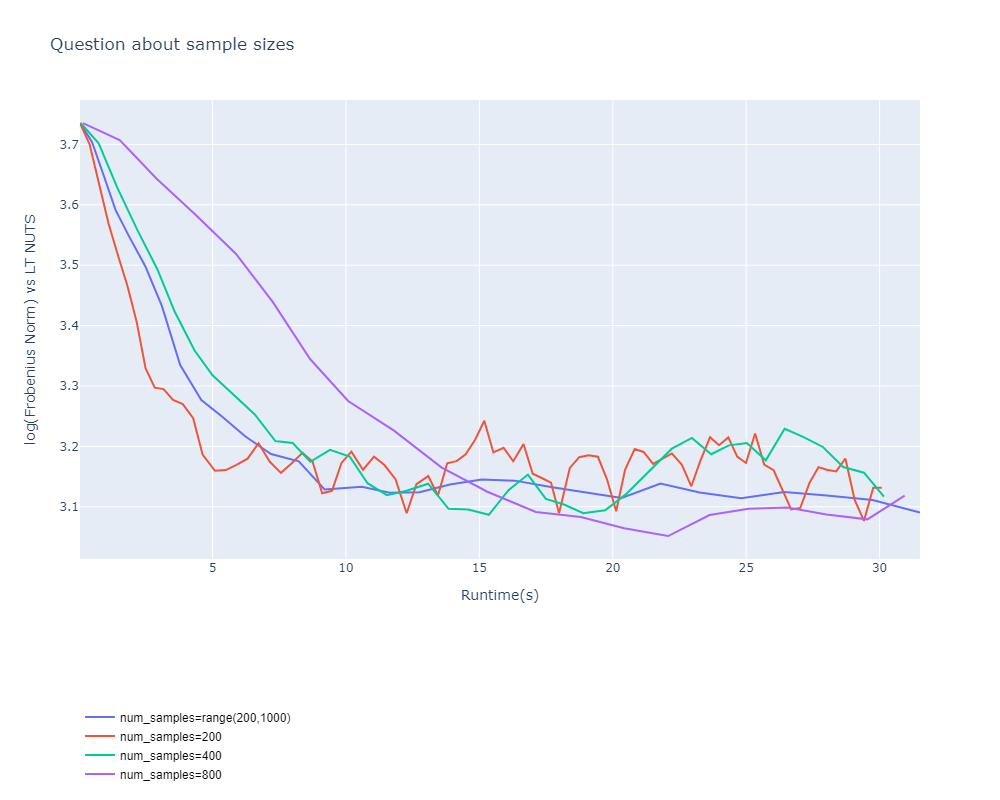

In [363]:
fig = go.Figure()

for num_samples in [0,200,400,800]:
    XY=FNByMethod3[(num_samples)]
    y=np.log(np.array([y for x,y in XY]))
    x=np.array([x for x,y in XY])
    name='num_samples={}'.format(num_samples)
    if not num_samples:
        name='num_samples=range(200,1000)'
    trace = go.Scatter(x=x, y=y, 
                       name=name)
    fig.add_trace(trace)

fig.update_layout(title='Question about sample sizes')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.update_layout(
    legend=dict(
        x=0,
        y=-0.5,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)
fig.show()

It is better to start off with smaller samples initially to boost the runtime, and then if time permits use larger samples later when the signal to noise ratio drops


## Question about value of u0

We can bootstrap of u0est from the SKlearn point estimate of standard error.


In [157]:
u0est

4.611216063346413

epoach 0 p 2 u0 1.0000 Frobenius Norm 90.1998
epoach 10 p 2 u0 1.0000 Frobenius Norm 89.9918
epoach 20 p 2 u0 1.0000 Frobenius Norm 89.7884
epoach 30 p 2 u0 1.0000 Frobenius Norm 89.5822
epoach 40 p 2 u0 1.0000 Frobenius Norm 89.5705
epoach 50 p 2 u0 1.0000 Frobenius Norm 89.4441
epoach 60 p 2 u0 1.0000 Frobenius Norm 89.0977
epoach 70 p 2 u0 1.0000 Frobenius Norm 88.8979
epoach 80 p 2 u0 1.0000 Frobenius Norm 88.7176
epoach 90 p 2 u0 1.0000 Frobenius Norm 88.5655
epoach 100 p 2 u0 1.0000 Frobenius Norm 88.4806
epoach 110 p 2 u0 1.0000 Frobenius Norm 88.2885
epoach 120 p 2 u0 1.0000 Frobenius Norm 88.2466
epoach 130 p 2 u0 1.0000 Frobenius Norm 88.1215
epoach 140 p 2 u0 1.0000 Frobenius Norm 87.8832
epoach 150 p 2 u0 1.0000 Frobenius Norm 87.8529
epoach 160 p 2 u0 1.0000 Frobenius Norm 87.5640
epoach 170 p 2 u0 1.0000 Frobenius Norm 87.5637
epoach 180 p 2 u0 1.0000 Frobenius Norm 87.4862
epoach 190 p 2 u0 1.0000 Frobenius Norm 87.3707
epoach 200 p 2 u0 1.0000 Frobenius Norm 87.3555
epo

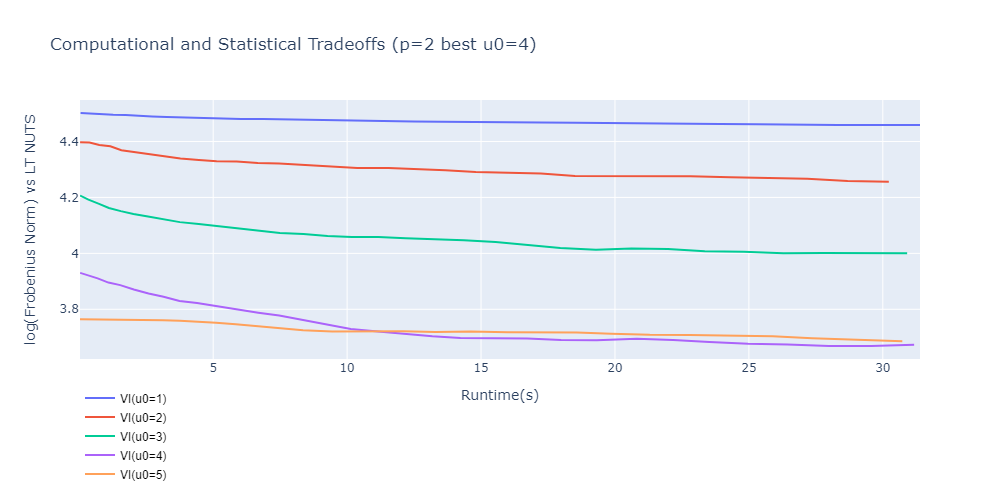

epoach 0 p 5 u0 1.0000 Frobenius Norm 80.0999
epoach 10 p 5 u0 1.0000 Frobenius Norm 79.4919
epoach 20 p 5 u0 1.0000 Frobenius Norm 79.0741
epoach 30 p 5 u0 1.0000 Frobenius Norm 78.7236
epoach 40 p 5 u0 1.0000 Frobenius Norm 77.8168
epoach 50 p 5 u0 1.0000 Frobenius Norm 77.1900
epoach 60 p 5 u0 1.0000 Frobenius Norm 76.7166
epoach 70 p 5 u0 1.0000 Frobenius Norm 76.3264
epoach 80 p 5 u0 1.0000 Frobenius Norm 76.0320
epoach 90 p 5 u0 1.0000 Frobenius Norm 75.3770
epoach 100 p 5 u0 1.0000 Frobenius Norm 75.1022
epoach 110 p 5 u0 1.0000 Frobenius Norm 74.6160
epoach 120 p 5 u0 1.0000 Frobenius Norm 74.2941
epoach 130 p 5 u0 1.0000 Frobenius Norm 73.6154
epoach 140 p 5 u0 1.0000 Frobenius Norm 73.1052
epoach 150 p 5 u0 1.0000 Frobenius Norm 72.6242
epoach 160 p 5 u0 1.0000 Frobenius Norm 72.1163
epoach 170 p 5 u0 1.0000 Frobenius Norm 71.7337
epoach 180 p 5 u0 1.0000 Frobenius Norm 71.1926
epoach 190 p 5 u0 1.0000 Frobenius Norm 70.6724
epoach 200 p 5 u0 1.0000 Frobenius Norm 70.3197
epo

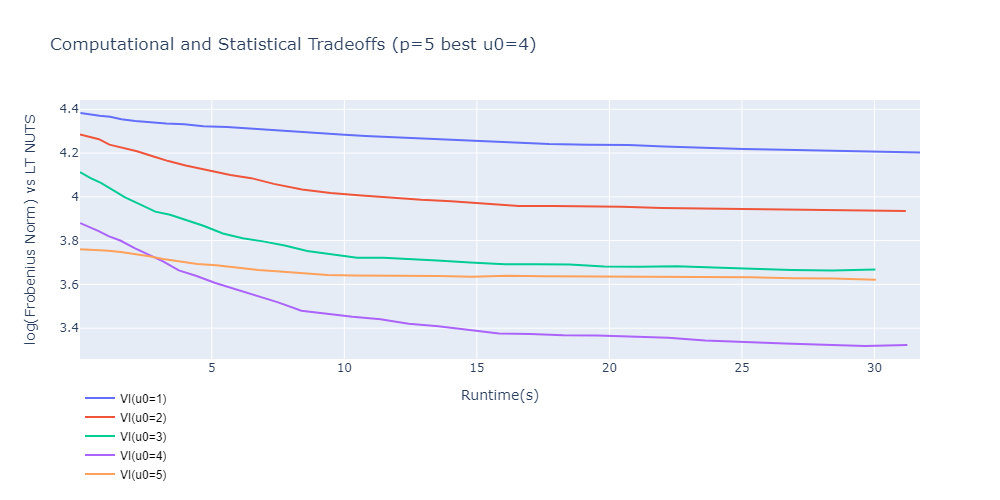

epoach 0 p 8 u0 1.0000 Frobenius Norm 67.3083
epoach 10 p 8 u0 1.0000 Frobenius Norm 66.8702
epoach 20 p 8 u0 1.0000 Frobenius Norm 66.6014
epoach 30 p 8 u0 1.0000 Frobenius Norm 66.0482
epoach 40 p 8 u0 1.0000 Frobenius Norm 66.0985
epoach 50 p 8 u0 1.0000 Frobenius Norm 65.5859
epoach 60 p 8 u0 1.0000 Frobenius Norm 64.8659
epoach 70 p 8 u0 1.0000 Frobenius Norm 64.5471
epoach 80 p 8 u0 1.0000 Frobenius Norm 63.5966
epoach 90 p 8 u0 1.0000 Frobenius Norm 62.9210
epoach 100 p 8 u0 1.0000 Frobenius Norm 62.0947
epoach 110 p 8 u0 1.0000 Frobenius Norm 61.5126
epoach 120 p 8 u0 1.0000 Frobenius Norm 60.7132
epoach 130 p 8 u0 1.0000 Frobenius Norm 60.0389
epoach 140 p 8 u0 1.0000 Frobenius Norm 59.4162
epoach 150 p 8 u0 1.0000 Frobenius Norm 58.3968
epoach 160 p 8 u0 1.0000 Frobenius Norm 57.9013
epoach 170 p 8 u0 1.0000 Frobenius Norm 56.9909
epoach 180 p 8 u0 1.0000 Frobenius Norm 56.3351
epoach 190 p 8 u0 1.0000 Frobenius Norm 55.6120
epoach 200 p 8 u0 1.0000 Frobenius Norm 55.1143
epo

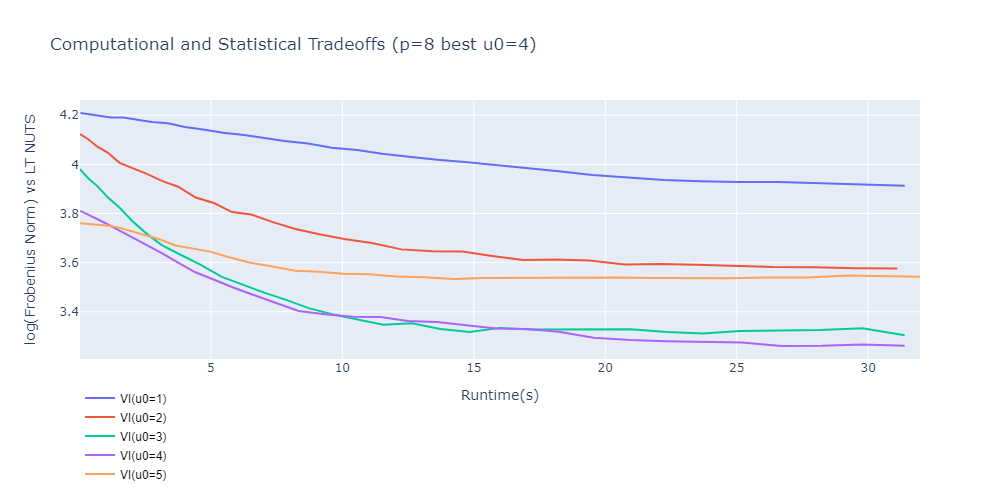

epoach 0 p 11 u0 1.0000 Frobenius Norm 56.6832
epoach 10 p 11 u0 1.0000 Frobenius Norm 55.8772
epoach 20 p 11 u0 1.0000 Frobenius Norm 54.8651
epoach 30 p 11 u0 1.0000 Frobenius Norm 53.4825
epoach 40 p 11 u0 1.0000 Frobenius Norm 53.1296
epoach 50 p 11 u0 1.0000 Frobenius Norm 51.7471
epoach 60 p 11 u0 1.0000 Frobenius Norm 50.4350
epoach 70 p 11 u0 1.0000 Frobenius Norm 49.5585
epoach 80 p 11 u0 1.0000 Frobenius Norm 48.4267
epoach 90 p 11 u0 1.0000 Frobenius Norm 46.6965
epoach 100 p 11 u0 1.0000 Frobenius Norm 45.7772
epoach 110 p 11 u0 1.0000 Frobenius Norm 44.4279
epoach 120 p 11 u0 1.0000 Frobenius Norm 43.3541
epoach 130 p 11 u0 1.0000 Frobenius Norm 42.2200
epoach 140 p 11 u0 1.0000 Frobenius Norm 40.6985
epoach 150 p 11 u0 1.0000 Frobenius Norm 40.1454
epoach 160 p 11 u0 1.0000 Frobenius Norm 39.7479
epoach 170 p 11 u0 1.0000 Frobenius Norm 38.8892
epoach 180 p 11 u0 1.0000 Frobenius Norm 37.8767
epoach 190 p 11 u0 1.0000 Frobenius Norm 37.3341
epoach 200 p 11 u0 1.0000 Frobe

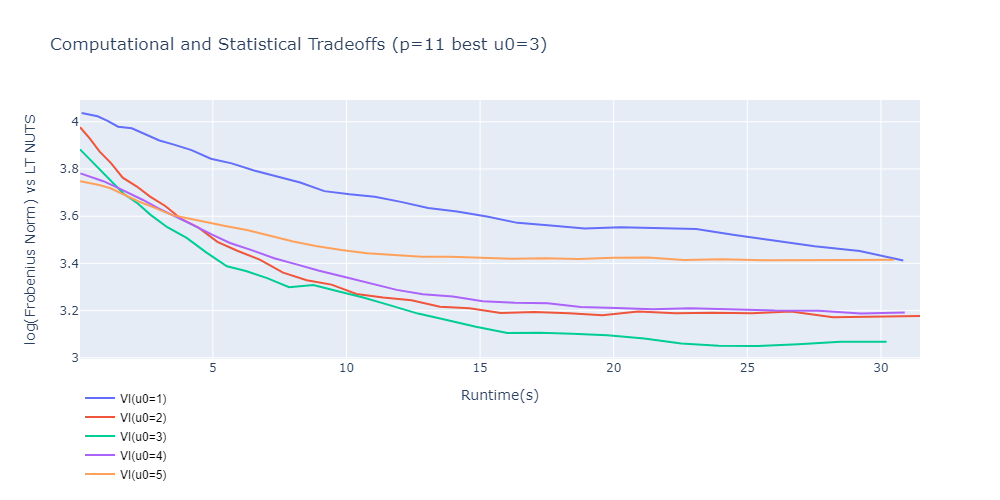

epoach 0 p 14 u0 1.0000 Frobenius Norm 41.9077
epoach 10 p 14 u0 1.0000 Frobenius Norm 40.6459
epoach 20 p 14 u0 1.0000 Frobenius Norm 37.5996
epoach 30 p 14 u0 1.0000 Frobenius Norm 35.4977
epoach 40 p 14 u0 1.0000 Frobenius Norm 33.8300
epoach 50 p 14 u0 1.0000 Frobenius Norm 31.3001
epoach 60 p 14 u0 1.0000 Frobenius Norm 29.5666
epoach 70 p 14 u0 1.0000 Frobenius Norm 27.4415
epoach 80 p 14 u0 1.0000 Frobenius Norm 26.8853
epoach 90 p 14 u0 1.0000 Frobenius Norm 26.5927
epoach 100 p 14 u0 1.0000 Frobenius Norm 25.2901
epoach 110 p 14 u0 1.0000 Frobenius Norm 23.6524
epoach 120 p 14 u0 1.0000 Frobenius Norm 22.5491
epoach 130 p 14 u0 1.0000 Frobenius Norm 22.5456
epoach 140 p 14 u0 1.0000 Frobenius Norm 22.4766
epoach 150 p 14 u0 1.0000 Frobenius Norm 22.2351
epoach 160 p 14 u0 1.0000 Frobenius Norm 21.5774
epoach 170 p 14 u0 1.0000 Frobenius Norm 20.9095
epoach 180 p 14 u0 1.0000 Frobenius Norm 21.6465
epoach 190 p 14 u0 1.0000 Frobenius Norm 21.9482
epoach 200 p 14 u0 1.0000 Frobe

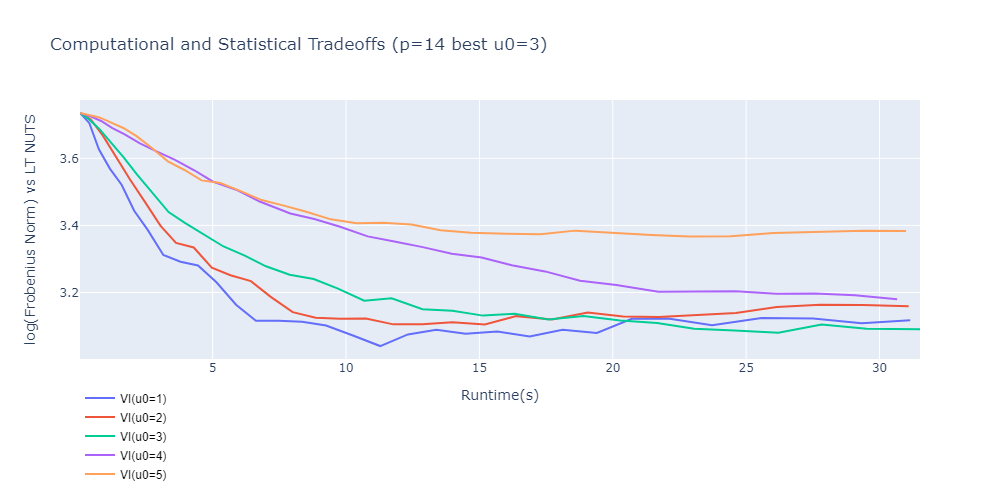

In [276]:
bestu0={}
for p in [2,5,8,11,14]:
    FNRT_By_u0=defaultdict(list)
    bestfb=np.inf
    for u0 in [1,2,3,4,5]:
        Λ = np.identity(p)
        U=np.eye(d,p)
        u0t,Ut,Λt=u0,U,Λ
        start=time.time()

        for t in range(10000):
            om=omega(u0t,Ut,Λt) #as per pdf 165

            num_samples=200+t*3
            samples,phis=getSamples(mu_star,om,num_samples) #Sample as per equation 6
            phis-=phis.mean()
            expphi=np.abs(phis).mean()        

            ht=0.01/(1+expphi)

            t2sum=0
            for thisphi,thetajt in zip(phis,samples):
                thetajt=(thetajt-mu_star).reshape((d,1))
                t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            t2sum/=num_samples
            Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)

            #update as per equation 8
            Ut, r = scipy.linalg.qr(Ut,mode='economic')

            if t%10==0: 
                #updating eigenvalues as per pdf 191
                om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
                for i in range(p):
                    ui=Ut[:,i]
                    Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-u0t**2

                om=omega(u0t,Ut,Λt) #as per pdf 165
                #suggested by mentor: Frobenius Norm
                fn=np.linalg.norm(oactual-om)
                estart=time.time()-start
                FNRT_By_u0[u0].append((estart,fn))
                if estart>30:
                    break
                print('epoach {} p {} u0 {:.4f} Frobenius Norm {:.4f}'.format(t,p,u0,fn))
        if fn<bestfb:
            bestu0[p]=u0
            bestfb=fn

    fig = go.Figure()

    for u0 in [1,2,3,4,5]:
        XY=FNRT_By_u0[u0]
        y=np.log(np.array([y for x,y in XY]))
        x=np.array([x for x,y in XY])
        trace = go.Scatter(x=x, y=y, 
                           name='VI(u0={})'.format(u0))
        fig.add_trace(trace)

    fig.update_layout(
        legend=dict(
            x=0,
            y=-0.5,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="black"
            ),
        )
    )

    fig.update_layout(title='Computational and Statistical Tradeoffs (p={} best u0={})'.format(p,bestu0[p]))
    fig.update_xaxes(title="Runtime(s)")
    fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
    fig.show()



In [278]:
bestu0

{2: 4, 5: 4, 8: 4, 11: 3, 14: 3}

# Trade off Analysis for different dimensions p

In [279]:
FNRT_ByPValue=defaultdict(list)
for p in [2,5,8,11,14]:
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=bestu0[p]
    u0t,Ut,Λt=u0,U,Λ
    start=time.time()

    for t in range(10000):
        om=omega(u0t,Ut,Λt) #as per pdf 165

        num_samples=200+t*3
        samples,phis=getSamples(mu_star,om,num_samples) #Sample as per equation 6
        phis-=phis.mean()
        expphi=np.abs(phis).mean()        

        ht=0.01/(1+expphi)

        t2sum=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
        t2sum/=num_samples
        Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)

        #update as per equation 8
        Ut, r = scipy.linalg.qr(Ut,mode='economic')

        if t%10==0: 
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-u0t**2

            om=omega(u0t,Ut,Λt) #as per pdf 165
            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            estart=time.time()-start
            FNRT_ByPValue[p].append((estart,fn))
            if estart>30:
                break
            print('epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(t,expphi,fn))


epoach 0 avg phi 1.1343 Frobenius Norm 50.9339
epoach 10 avg phi 1.2289 Frobenius Norm 50.5173
epoach 20 avg phi 1.1867 Frobenius Norm 49.8605
epoach 30 avg phi 1.1803 Frobenius Norm 49.1937
epoach 40 avg phi 1.0288 Frobenius Norm 48.3902
epoach 50 avg phi 1.1811 Frobenius Norm 47.5698
epoach 60 avg phi 1.0892 Frobenius Norm 46.6370
epoach 70 avg phi 1.2135 Frobenius Norm 46.0812
epoach 80 avg phi 1.1167 Frobenius Norm 45.9456
epoach 90 avg phi 1.0626 Frobenius Norm 45.3446
epoach 100 avg phi 1.1287 Frobenius Norm 44.5232
epoach 110 avg phi 1.0137 Frobenius Norm 43.6687
epoach 120 avg phi 1.0691 Frobenius Norm 43.4615
epoach 130 avg phi 1.0231 Frobenius Norm 42.9782
epoach 140 avg phi 1.0471 Frobenius Norm 42.5222
epoach 150 avg phi 1.0767 Frobenius Norm 42.0635
epoach 160 avg phi 1.0709 Frobenius Norm 41.5931
epoach 170 avg phi 1.0022 Frobenius Norm 41.3817
epoach 180 avg phi 0.9805 Frobenius Norm 41.3424
epoach 190 avg phi 1.0477 Frobenius Norm 41.1291
epoach 200 avg phi 1.0721 Frobe

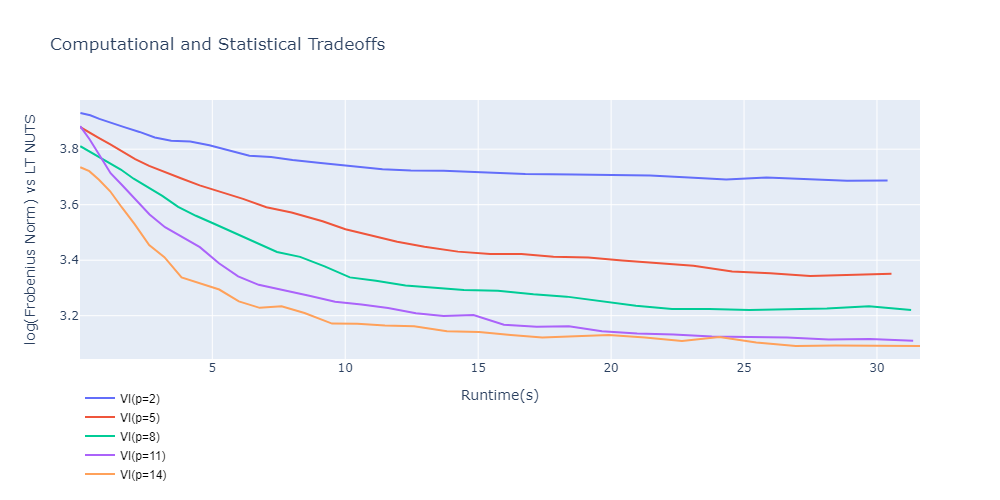

In [280]:

import plotly.graph_objects as go

fig = go.Figure()

for p in [2,5,8,11,14]:
    XY=FNRT_ByPValue[p]
    y=np.log(np.array([y for x,y in XY]))
    x=np.array([x for x,y in XY])
    trace = go.Scatter(x=x, y=y, 
                       name='VI(p={})'.format(p))
    fig.add_trace(trace)

fig.update_layout(title='Computational and Statistical Tradeoffs')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.update_layout(
    legend=dict(
        x=0,
        y=-0.5,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)

fig.update_layout(title='Computational and Statistical Tradeoffs')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.show()

Using the full rank p=14 is best.

This is probably because most of the computation is in evaluating phi, and that costs the same even if p is small.



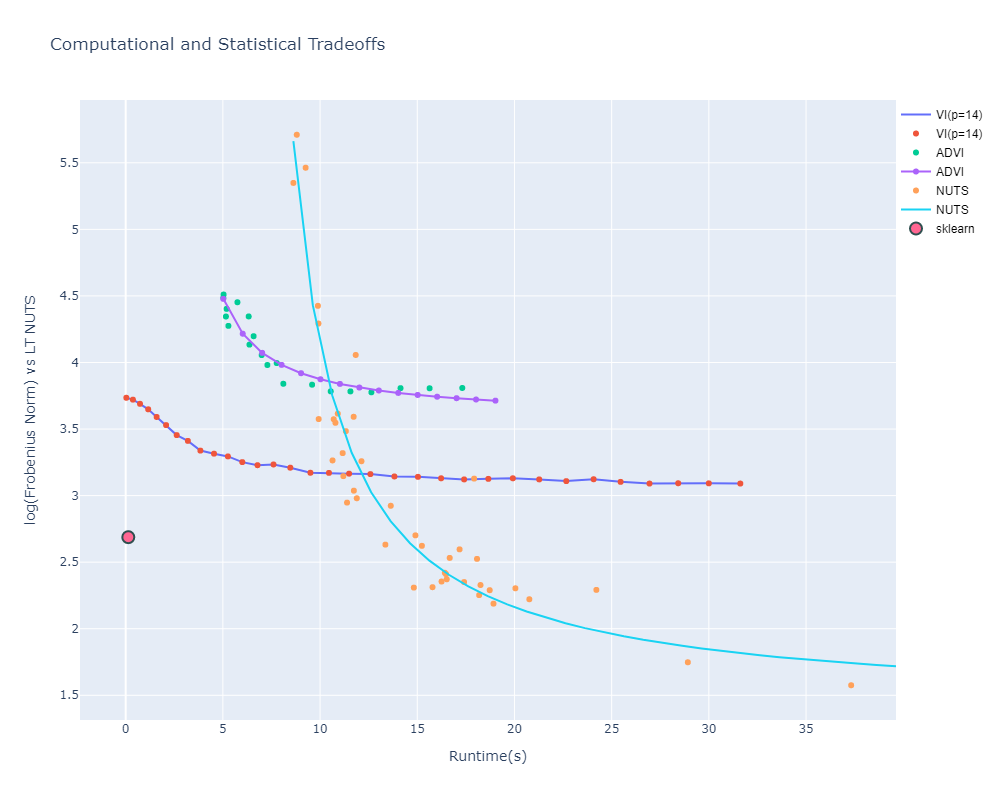

In [292]:
png_renderer.width = 1000
png_renderer.height = 800

fig = go.Figure()

for p in [14]:
    XY=FNRT_ByPValue[p]
    y=np.log(np.array([y for x,y in XY]))
    x=np.array([x for x,y in XY])
    trace = go.Scatter(x=x, y=y, 
                       name='VI(p={})'.format(p))
    fig.add_trace(trace)
    trace = go.Scatter(x=x, y=y, mode='markers',
                       name='VI(p={})'.format(p))
    fig.add_trace(trace)

fig.update_layout(title='Computational and Statistical Tradeoffs')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.update_layout(
    legend=dict(
        x=1,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)

maxX=40
for res,l,col in [(ADVItimeToFN,'ADVI','blue'),(NUTStimeToFN,'NUTS','red')]:
    XY=sorted(zip(res.keys(),res.values()))
    X=np.array([x[0] for x in XY])
    y=np.array([np.log(x[1]) for x in XY])
    trace = go.Scatter(x=X[X<maxX], y=y[X<maxX],mode='markers',name=l)
    fig.add_trace(trace)
    #fit,param=np.polynomial.polynomial.Polynomial.fit(X,y, 6, full=True)
    #params,_=scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(t-c**2),  X,  y)
    params,_=scipy.optimize.curve_fit(lambda t,a,b,c: a+b*(1/np.clip(t+c,0.0001,None)),  X,  y)
    a=params[0]
    b=params[1]
    c=params[2]
    def fit(t):
        return a+b*(1/np.clip(t+c,0.0001,None))
    plotrange=np.arange(min(X),min(max(X)*1.1,maxX))
    trace = go.Scatter(x=plotrange, y=fit(plotrange),name=l)
    fig.add_trace(trace)

trace = go.Scatter(x=[sklearnruntime], y=[np.log(sklearnfn)],mode='markers',name='sklearn',
                  marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')))
fig.add_trace(trace)

    
fig.update_layout(title='Computational and Statistical Tradeoffs')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.show()

VI beats ADVI in all runtimes.

And VI beats NUTS for runtimes under 11 seconds


# Seeding with SKLearn

Don't actually use oactual


In [218]:
FNRT_ByPValue=defaultdict(list)
for p in [14,11,8,5,2]:
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=u0est
    u0t,Ut,Λt=u0,U,Λ
    start=time.time()

    for t in range(10000):
        om=omega(u0t,Ut,Λt) #as per pdf 165

        num_samples=200+t*3
        samples,phis=getSamples(mu_star,om,num_samples) #Sample as per equation 6
        phis-=phis.mean()
        expphi=np.abs(phis).mean()        

        ht=0.01/(1+expphi)

        t2sum=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
        t2sum/=num_samples
        Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)

        #update as per equation 8
        Ut, r = scipy.linalg.qr(Ut,mode='economic')

        if t%10==0: 
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,sklearnom),ui)-u0t**2

            om=omega(u0t,Ut,Λt) #as per pdf 165
            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            estart=time.time()-start
            FNRT_ByPValue[p].append((estart,fn))
            if estart>30:
                break
            print('epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(t,expphi,fn))


epoach 0 avg phi 0.8740 Frobenius Norm 43.8830
epoach 10 avg phi 0.7672 Frobenius Norm 43.6645
epoach 20 avg phi 0.7945 Frobenius Norm 43.2467
epoach 30 avg phi 0.6456 Frobenius Norm 42.6940
epoach 40 avg phi 0.7352 Frobenius Norm 41.9287
epoach 50 avg phi 0.8243 Frobenius Norm 41.1800
epoach 60 avg phi 0.7381 Frobenius Norm 40.4719
epoach 70 avg phi 0.7102 Frobenius Norm 39.8194
epoach 80 avg phi 0.7347 Frobenius Norm 39.1112
epoach 90 avg phi 0.7144 Frobenius Norm 38.2448
epoach 100 avg phi 0.7306 Frobenius Norm 37.4705
epoach 110 avg phi 0.6492 Frobenius Norm 36.8157
epoach 120 avg phi 0.7002 Frobenius Norm 35.8657
epoach 130 avg phi 0.7138 Frobenius Norm 35.0876
epoach 140 avg phi 0.6940 Frobenius Norm 34.3461
epoach 150 avg phi 0.6837 Frobenius Norm 33.6646
epoach 160 avg phi 0.7045 Frobenius Norm 33.0329
epoach 170 avg phi 0.6821 Frobenius Norm 32.5751
epoach 180 avg phi 0.6879 Frobenius Norm 32.0939
epoach 190 avg phi 0.7181 Frobenius Norm 31.5996
epoach 200 avg phi 0.6958 Frobe

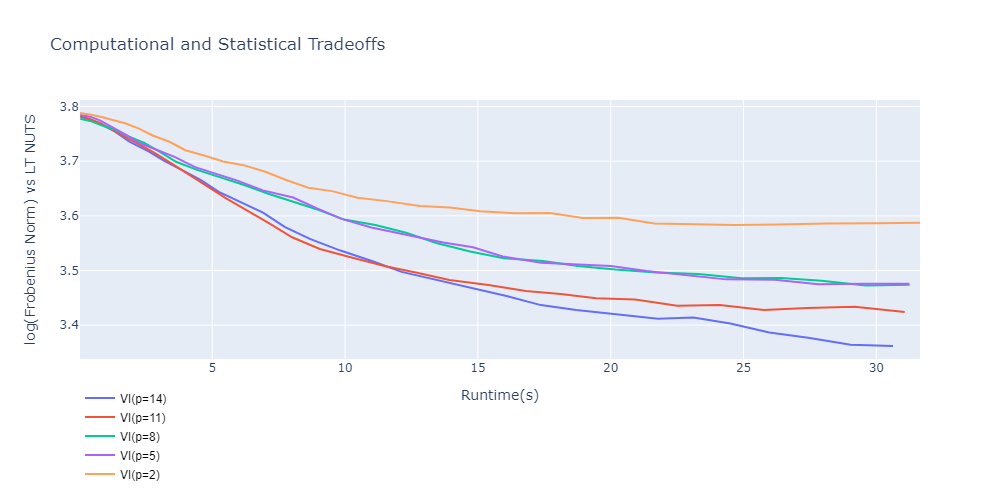

In [219]:

import plotly.graph_objects as go

fig = go.Figure()

for p in [14,11,8,5,2]:
    XY=FNRT_ByPValue[p]
    y=np.log(np.array([y for x,y in XY]))
    x=np.array([x for x,y in XY])
    trace = go.Scatter(x=x, y=y, 
                       name='VI(p={})'.format(p))
    fig.add_trace(trace)

fig.update_layout(title='Computational and Statistical Tradeoffs')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.update_layout(
    legend=dict(
        x=0,
        y=-0.5,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)

fig.update_layout(title='Computational and Statistical Tradeoffs')
fig.update_xaxes(title="Runtime(s)")
fig.update_yaxes(title="log(Frobenius Norm) vs LT NUTS")
fig.show()

In [200]:
sklearnom

array([[ 28.88852954,  -0.18892812,   4.32947081,   1.10360396,
         -0.20669126,   0.57620141,   0.28231002,  -0.18364454,
          2.48319408,  -0.85161407,  -1.88389268,   0.10732446,
         -3.64377599,   1.52734446],
       [ -0.18892812,  27.69068339,  -6.60102871,  -0.48447964,
          5.26524795,   6.41134977,   3.73859512,   0.8211732 ,
         -9.25230819,   0.23155852,   0.58600563,   1.93735247,
          6.38089728,  -0.18365395],
       [  4.32947081,  -6.60102871,  25.49366121,  -3.21336479,
         -4.48241794, -11.06039124,   1.71053842,  -0.91247557,
          3.51421228,  -1.56779312,   0.14636887,  -1.43007745,
         -1.38655017,   8.33905818],
       [  1.10360396,  -0.48447964,  -3.21336479,  29.0784091 ,
         -5.63721675,   0.19764137,  -3.13269537,  -1.88826453,
         -3.72899813,   6.08252357,  -2.96406575,  -1.62727452,
         -0.16202864,   1.79802254],
       [ -0.20669126,   5.26524795,  -4.48241794,  -5.63721675,
         30.54465635

In [241]:
from numpy.linalg import eigh
vals, vecs = eigh(sklearnom-np.identity(d)*49)
np.linalg.norm(oactual-sklearnom)

14.699078677126952

In [242]:
vals

array([-40.12234356, -37.3639539 , -36.59176623, -33.03850502,
       -29.4830865 , -25.01649652, -23.78761627, -21.70952175,
       -19.31454486, -16.08645413, -13.5628198 ,  -6.97545387,
        -1.84877429,   4.07438725])

In [247]:
idx = np.argsort(np.abs(vals))
vals = vals[idx]
vecs = vecs[:,idx]    
vals

array([ -1.84877429,   4.07438725,  -6.97545387, -13.5628198 ,
       -16.08645413, -19.31454486, -21.70952175, -23.78761627,
       -25.01649652, -29.4830865 , -33.03850502, -36.59176623,
       -37.3639539 , -40.12234356])

In [246]:
FNRT_ByPValue2=defaultdict(list)
for p in [11,8,5,2]:
    Λ = np.identity(p)
    U= vecs[:,-p:]
    u0=7
    u0t,Ut,Λt=u0,U,Λ
    
    om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
    for i in range(p):
        ui=Ut[:,i]
        Λt[i][i]=np.matmul(np.matmul(ui.T,sklearnom),ui)-u0t**2
    om=omega(u0t,Ut,Λt) #as per pdf 165
    fn=np.linalg.norm(oactual-om)
    print('Frobenius Norm {:.4f}'.format(fn))
    
    start=time.time()

    for t in range(10000):
        om=omega(u0t,Ut,Λt) #as per pdf 165

        num_samples=10000
        samples,phis=getSamples(mu_star,om,num_samples) #Sample as per equation 6
        phis-=phis.mean()
        expphi=np.abs(phis).mean()        

        ht=0.01/(1+expphi)

        t2sum=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
        t2sum/=num_samples
        Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)

        #update as per equation 8
        Ut, r = scipy.linalg.qr(Ut,mode='economic')

        if t%10==0: 
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,sklearnom),ui)-u0t**2

            om=omega(u0t,Ut,Λt) #as per pdf 165
            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            estart=time.time()-start
            FNRT_ByPValue2[p].append((estart,fn))
            if estart>30:
                break
            print('epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(t,expphi,fn))

            

Frobenius Norm 18.1364
epoach 0 avg phi 0.7033 Frobenius Norm 18.0748
epoach 10 avg phi 0.7228 Frobenius Norm 20.1782
epoach 20 avg phi 0.7030 Frobenius Norm 21.7774
Frobenius Norm 38.8337
epoach 0 avg phi 0.6537 Frobenius Norm 38.8007
epoach 10 avg phi 0.6593 Frobenius Norm 40.1898
epoach 20 avg phi 0.6469 Frobenius Norm 41.7194
Frobenius Norm 60.2614
epoach 0 avg phi 0.6146 Frobenius Norm 60.2552
epoach 10 avg phi 0.5889 Frobenius Norm 61.5453
epoach 20 avg phi 0.5760 Frobenius Norm 62.9582
Frobenius Norm 85.7290
epoach 0 avg phi 0.5230 Frobenius Norm 85.7354
epoach 10 avg phi 0.5105 Frobenius Norm 86.2174
epoach 20 avg phi 0.5134 Frobenius Norm 86.4696


# Sklearn might not scale...memory errors


In [367]:
multiple=10000
XData2=np.vstack([XData]*multiple)
yData2=np.hstack([yData]*multiple)


start = time.time()
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(XData2, yData2)
#From https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients

# Calculate matrix of predicted class probabilities.
# Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
predProbs = clf.predict_proba(XData2)

# Design matrix -- add column of 1's at the beginning of your X_train matrix
X_design = np.hstack([np.ones((XData2.shape[0], 1)), XData2])
#X_design=scipy.sparse.csr_matrix(X_design)

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
# V = np.diagflat(np.product(predProbs, axis=1))
# V=scipy.sparse.diags(np.product(predProbs, axis=1)) #Sparse or it would be size N^2

V = np.product(predProbs, axis=1)


# Covariance matrix
# Note that the @-operater does matrix multiplication in Python 3.5+, so if you're running
# Python 3.5+, you can replace the covLogit-line below with the more readable:
# covLogit = np.linalg.inv(X_design.T @ V @ X_design)
#covLogit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
#covLogit = np.linalg.inv(X_design.T.dot(V).dot(X_design).todense())
covLogit = np.linalg.pinv(np.dot(X_design.T* V, X_design))

#print("Covariance matrix: ", covLogit)

# Standard errors
print("Coefs: ", clf.coef_)
print("Intercept: ", clf.intercept_)
print("Standard errors: ", np.sqrt(np.diag(covLogit)))
print("Average Standard errors: ", np.mean(np.sqrt(np.diag(covLogit))))
print("Average u0 = {}".format(np.sqrt(np.diag(om)).mean()))
print()
sklearnruntime = time.time()-start
accuracy=clf.score(XData, yData)
print('SKlearn Logistic Regression Accuracy ={:.3f} Runtime(s) = {:.2f}'.format(accuracy,sklearnruntime))

sklearnom=np.linalg.inv(covLogit)
sklearnfn=np.linalg.norm(oactual-sklearnom)
print('For SKLearn, FN ={} log(FN)={}'.format(sklearnfn,np.log(sklearnfn)))

KeyboardInterrupt: 

In [358]:
np.dot(X_design.T, V)

array([2774.75678933,  -39.05232401,  438.36799492,  110.68354695,
        -15.43307675,   67.42587047,   18.1101579 ,  -26.55234177,
        262.9230506 ,  -83.81665027, -186.02185048,    6.11306943,
       -369.16981964,  148.7666935 ])

In [348]:
sklearnom

matrix([[ 56.67191212,  -0.57434346,   8.71434377,   2.20787159,
          -0.36373334,   1.24551021,   0.46888591,  -0.44565634,
           5.11157813,  -1.69389692,  -3.74885458,   0.16846919,
          -7.33659649,   3.01616406],
        [ -0.57434346,  54.31212424, -13.00552122,  -0.93467428,
          10.27309644,  12.6544125 ,   7.38247743,   1.49536383,
         -18.16009511,   0.5211326 ,   0.99924912,   3.77562427,
          12.40301466,  -0.2547781 ],
        [  8.71434377, -13.00552122,  49.84419527,  -6.41975953,
          -8.9214648 , -21.90085578,   3.32785645,  -1.84439106,
           7.0243631 ,  -3.37800522,   0.22189555,  -2.91178003,
          -2.89125941,  16.09438961],
        [  2.20787159,  -0.93467428,  -6.41975953,  57.05344817,
         -11.17867331,   0.29234668,  -6.0752532 ,  -3.82408807,
          -7.10633138,  11.85714389,  -5.97639752,  -3.22820176,
          -0.64539432,   3.43958695],
        [ -0.36373334,  10.27309644,  -8.9214648 , -11.17867331,
   

In [340]:
predProbs[0]

array([0.00947411, 0.99052589])

In [341]:
predProbs[270]

array([0.00947411, 0.99052589])